### Machine Learning Project

# Water potability classification 

##### BAHA Manon - HADDOUCHI Imane - VIEILLARD Marine

Access to clean drinking water is a fundamental issue for public health and sustainable development. However, millions of people worldwide continue to suffer from illnesses caused by unsafe water.

As part of this project, we have chosen to work on water potability classification using machine learning models. This topic is important because it addresses environmental, health, and technological challenges.

##### Data

We decided to study a dataset from Kaggle, named "Water Quality Prediction" (https://www.kaggle.com/datasets/vanthanadevi08/water-quality-prediction/data). 

Our main goal is to estimate water potability based on parameters such as pH, nitrate levels, color, source, and more.

Simple training experiments (without PCA, cross-validation, etc.) have already been conducted on this dataset, excluding qualitative features. Our objective is to build upon and deepen the analysis of this dataset by including qualitative features in the training process and conducting more comprehensive training sessions. We have chosen to restart the study from scratch to achieve this goal.

### Packages loading

In [1]:
# Importation of all the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,  StratifiedShuffleSplit,StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from joblib import Parallel, delayed




# Preprocessing 

##### Data exploration : getting info from the data, dropping unusefull features

In [2]:
# Data reading
data = pd.read_csv('Data/Water Quality Prediction.csv')
data.head()


# Data info
print("Data Information:")
data.info()
print("\nNumber of unique values per column:")
print(data.nunique())

# Unusefull feature dropping
features_to_drop = ['Index','Month','Day','Time of Day']
data.drop(columns=features_to_drop, inplace=True)

data.head()

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Index                   1048575 non-null  int64  
 1   pH                      1028344 non-null  float64
 2   Iron                    1041584 non-null  float64
 3   Nitrate                 1029880 non-null  float64
 4   Chloride                1017741 non-null  float64
 5   Lead                    1043891 non-null  float64
 6   Zinc                    1020900 non-null  float64
 7   Color                   1047594 non-null  object 
 8   Turbidity               1039881 non-null  float64
 9   Fluoride                1015357 non-null  float64
 10  Copper                  1013693 non-null  float64
 11  Odor                    1017243 non-null  float64
 12  Sulfate                 1014050 non-null  float64
 13  Conductivity            1019772 non-nul

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Target
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,0
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,0
2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,3.414619,275.702107,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,0
3,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,Near Colorless,0.166319,0.208454,0.239451,NaN,147.163233,237.028468,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,0
4,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,Light Yellow,0.004867,0.222912,0.616574,0.795310,175.275175,385.025855,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,0


#### NaN values location visualization 

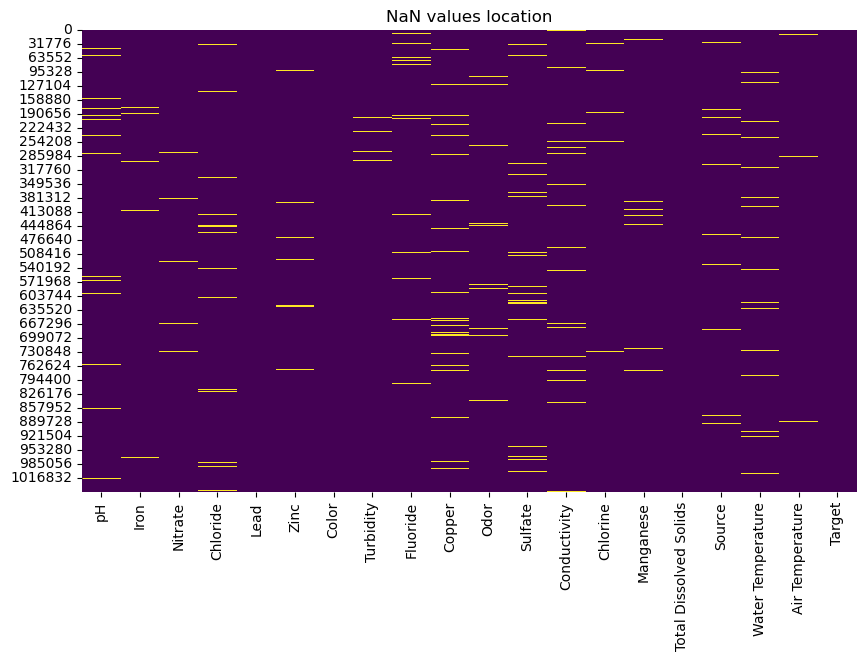

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna(), cbar=False, cmap="viridis")
plt.title("NaN values location")
plt.show()

#### NaN values processing

In [3]:
# Percentage of NaN values before processing
nan_percentage = data.isna().mean() * 100
print("\nPercentage of missing values before processing:\n", nan_percentage)

# Dropping columns with more than 50% NaN values
data.drop(columns=nan_percentage[nan_percentage > 50].index, inplace=True)

# Identifying numerical and categorical columns
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

# Imputing missing values
num_imputer = SimpleImputer(strategy='mean')  # Mean for numerical columns
cat_imputer = SimpleImputer(strategy='most_frequent')  # Mode for categorical columns

data[num_cols] = num_imputer.fit_transform(data[num_cols])
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Checking for NaN values after imputation
print("\nMissing values after processing:\n", data.isna().sum())


Percentage of missing values before processing:
 pH                        1.929380
Iron                      0.666714
Nitrate                   1.782896
Chloride                  2.940562
Lead                      0.446701
Zinc                      2.639296
Color                     0.093556
Turbidity                 0.829125
Fluoride                  3.167918
Copper                    3.326610
Odor                      2.988055
Sulfate                   3.292564
Conductivity              2.746871
Chlorine                  0.969125
Manganese                 1.844313
Total Dissolved Solids    0.028420
Source                    1.481534
Water Temperature         2.831271
Air Temperature           0.505734
Target                    0.000000
dtype: float64

Missing values after processing:
 pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Color                     0
Turb

#### Features distribution

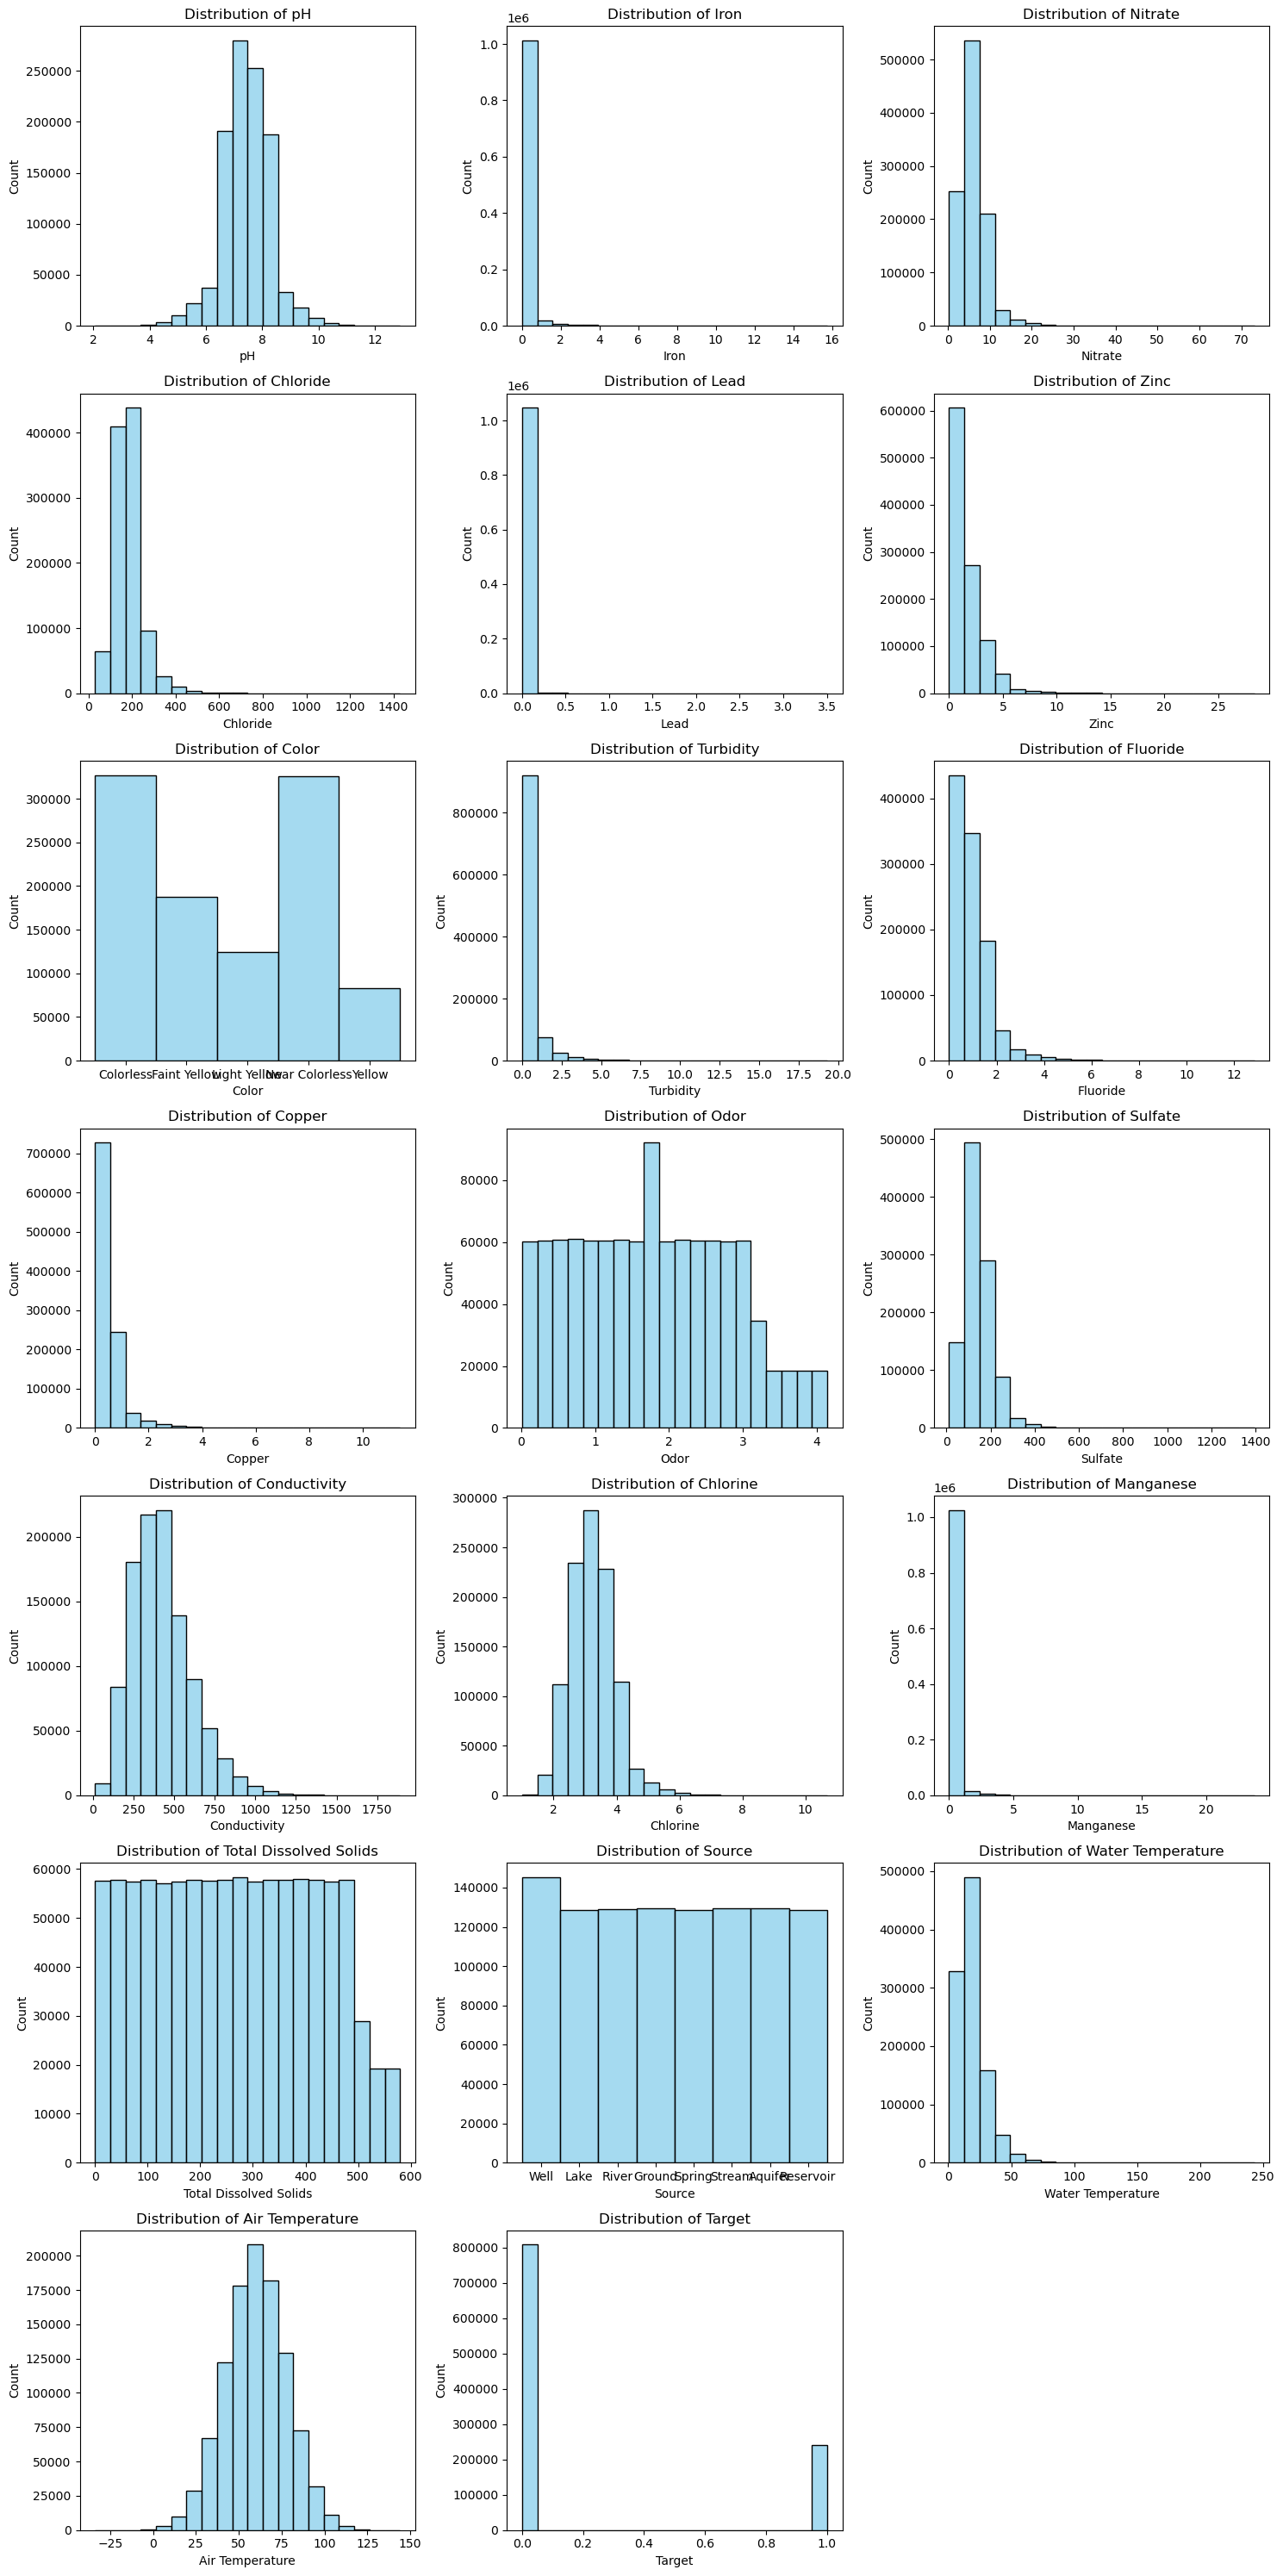

In [5]:
plt.figure(figsize=(15, 30))
    
for i, column in enumerate(data.columns, 1):
    plt.subplot(len(data.columns) // 3 + 1, 3, i)
    sns.histplot(data[column], kde=False, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {column}")
      
plt.tight_layout()
plt.show()


#### Encoding categorical columns

In [4]:
# Encoding categorical columns
df_cat = data.select_dtypes(include=['object']).copy()
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_cat_encoded = cat_encoder.fit_transform(df_cat)
df_cat_encoded = pd.DataFrame(df_cat_encoded, columns=cat_encoder.get_feature_names_out(df_cat.columns))

df_cat_encoded.index = data.index
data = pd.concat([data.drop(cat_cols, axis=1), df_cat_encoded], axis=1)

# Update cat_cols to reflect the newly encoded columns
cat_cols_encoded = df_cat_encoded.columns

# Visualizing categorical columns before and after encoding
print("\nCategorical columns before encoding:\n", df_cat.head())
print("\nCategorical columns after encoding:\n", df_cat_encoded.head())

# Descriptive statistics
print("\nDescriptive statistics of numerical data:\n", data.describe())

# Using the newly encoded categorical columns
print("\nNumber of categories per categorical variable:\n", data[cat_cols_encoded].nunique())



Categorical columns before encoding:
             Color  Source
0       Colorless    Well
1    Faint Yellow    Lake
2    Light Yellow   River
3  Near Colorless  Ground
4    Light Yellow  Spring

Categorical columns after encoding:
    Color_Colorless  Color_Faint Yellow  Color_Light Yellow  \
0              1.0                 0.0                 0.0   
1              0.0                 1.0                 0.0   
2              0.0                 0.0                 1.0   
3              0.0                 0.0                 0.0   
4              0.0                 0.0                 1.0   

   Color_Near Colorless  Color_Yellow  Source_Aquifer  Source_Ground  \
0                   0.0           0.0             0.0            0.0   
1                   0.0           0.0             0.0            0.0   
2                   0.0           0.0             0.0            0.0   
3                   1.0           0.0             0.0            1.0   
4                   0.0           

#### Data scaling using MinMax method

In [5]:
# Data scalling
scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
data.describe().loc[['min', 'mean', 'std', 'max']].T.style.background_gradient(axis=1)

,min,mean,std,max
pH,0.000000,0.497682,0.077500,1.000000
Iron,0.000000,0.007236,0.028056,1.000000
Nitrate,0.000000,0.079581,0.042643,1.000000
Chloride,0.000000,0.108806,0.046243,1.000000
Lead,0.000000,0.000369,0.008628,1.000000
Zinc,0.000000,0.053895,0.052362,1.000000
Turbidity,0.000000,0.025062,0.044459,1.000000
Fluoride,0.000000,0.073221,0.060680,1.000000
Copper,0.000000,0.043364,0.048878,1.000000
Odor,0.000000,0.426481,0.250664,1.000000


#### Distribution of the target


Distribution of the target variable:
Target
0.0    807841
1.0    240734
Name: count, dtype: int64


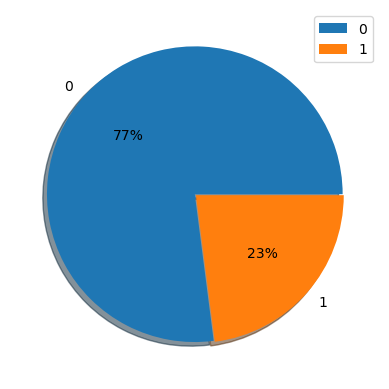

In [9]:
# Visualizing the distribution of the target variable
tar = data['Target'].value_counts()
print("\nDistribution of the target variable:")
print(tar)

plt.pie(tar, labels=[0, 1], explode=[0, 0.01], autopct='%.f%%', shadow=True)
plt.legend()
plt.show()

#### Correlation matrix

Color_Yellow    0.256488
Turbidity       0.237234
Copper          0.221141
Chloride        0.207777
Manganese       0.197144
Name: Target, dtype: float64


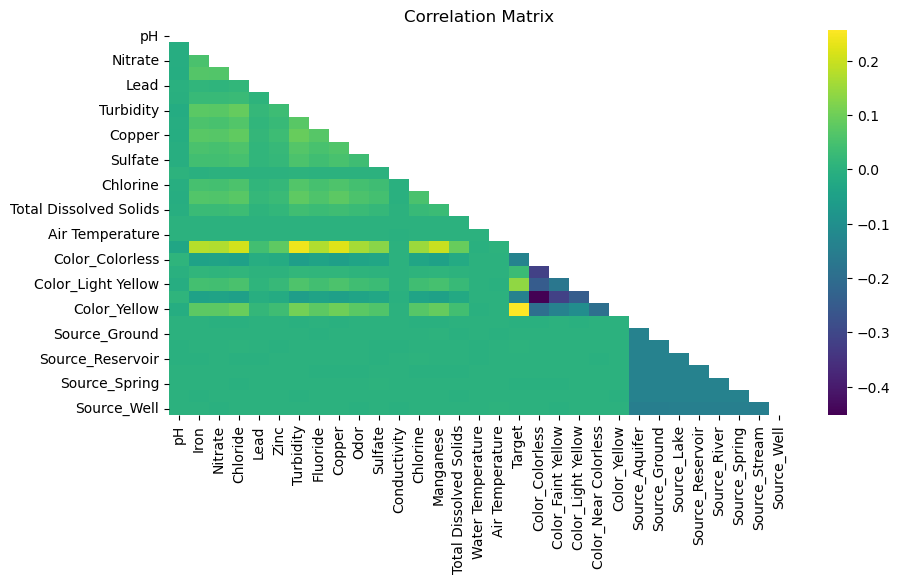

In [6]:
corr_matrix = data.corr(numeric_only=True)
target_corr = corr_matrix['Target'].drop('Target')  # Ignore correlation with itself

# Sort correlations by absolute value and get the top 5
top_5_corr = target_corr.abs().sort_values(ascending=False).head(5)

# Print the names of the top 5 most correlated columns
print(top_5_corr)

# Display the heatmap
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    annot=False, cmap="viridis", mask=mask, cbar=True
)
plt.title("Correlation Matrix")
plt.show()

# Training 

#### Gridsearch to find the best n_components for PCA

In [ ]:
X = data.drop('Target', axis=1)
y_target = data['Target']

pca = PCA()
mod = GaussianNB()  #choice of gaussianNB because the accuracy score is one of the best and calculation time is ok
SCORINGS = "accuracy"

pipe = Pipeline(
    steps=[
		("pca", pca),
        ("mod", mod)
	]
)

param_grid =  {"pca__n_components": [20,25,27,30]}

search = GridSearchCV(pipe, param_grid, n_jobs = -1, scoring= SCORINGS, verbose = 1, cv=5)

search.fit(X, y_target)

#Print the best prediction score obtained, it correspond to the hyperparameter value

print(f"Best parameter (f1-score: {search.best_score_: .3f})")

print(search.best_params_)

cv_results_df = pd.DataFrame(search.cv_results_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\marin\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Best parameter (f1-score:  nan)
{'pca__n_components': 20}


In [8]:
# Appliquer la PCA avec n_components = 25
n_components = 25
pca = PCA(n_components=n_components)

# Transformation des données
X_pca = pca.fit_transform(X)

# Convertir les résultats PCA en DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])

# Affichage des 5 premières lignes des données transformées
print("\nLes 5 premières lignes des données après PCA :")
print(X_pca_df.head())


Les 5 premières lignes des données après PCA :
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.708514 -0.335861 -0.110724  0.916975  0.000434 -0.003639 -0.007386   
1 -0.003361  0.847721 -0.398902 -0.150084 -0.016817  0.051350  0.235360   
2 -0.000932  0.356242  0.948826 -0.124252 -0.005033  0.084953  0.574823   
3 -0.706316 -0.344883 -0.111217 -0.155050 -0.081627  0.722228 -0.549000   
4 -0.003733  0.315029  0.893282 -0.121272  0.004426  0.047971  0.188743   

        PC8       PC9      PC10  ...      PC16      PC17      PC18      PC19  \
0  0.003358  0.000155  0.001621  ... -0.077850  0.052191 -0.032431  0.050472   
1 -0.457006  0.763539 -0.085732  ...  0.047189 -0.004152 -0.030495 -0.009254   
2  0.718959  0.061094 -0.024124  ...  0.181433 -0.003590 -0.061635 -0.029247   
3  0.161638  0.022153 -0.008045  ... -0.043429  0.034183 -0.046447  0.089725   
4 -0.318212 -0.343094  0.752544  ... -0.061434 -0.007880 -0.045176  0.088238   

       PC20      PC2

# Training

### Split the data

In [9]:
X_selected = X_pca_df
y_target = data['Target']
x_train, x_test, y_train, y_test = train_test_split(X_selected, y_target, test_size=0.2, random_state=42)


### Training without cross validation 

In [15]:
# Models list
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Gaussian NB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

def train_and_evaluate_model(name, model, x_train, y_train, x_test, y_test):
    """Trains a model, makes predictions, and calculates metrics."""
    print(f"Processing {name}...")
    
    model.fit(x_train, y_train)
    
    # Predictions and probabilities
    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:, 1] 
    
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_probs),
        'F1 Score': f1_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)  
    }
    
    return metrics

# Function to train all models in parallel
def parallel_training(models, x_train, y_train, x_test, y_test):
    """Trains all models in parallel and returns the results in a DataFrame."""
    results = Parallel(n_jobs=-1)(
        delayed(train_and_evaluate_model)(name, model, x_train, y_train, x_test, y_test)
        for name, model in models.items()
    )
    return pd.DataFrame(results).sort_values(by="A", ascending=False)

# Function to display a confusion matrix (with saving to a file)
def plot_confusion_matrix(cm, model_name):
    """Generates and saves a confusion matrix."""
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=['Non-potable', 'Potable'], 
                yticklabels=['Non-potable', 'Potable'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predictions')
    plt.ylabel('Real')
    plt.savefig(f"confusion_matrix_{model_name}.png")
    plt.close()  # Close the figure to save memory

# Function to display all confusion matrices in parallel
def plot_all_confusion_matrices_parallel(results_df):
    """Displays all confusion matrices in parallel."""
    Parallel(n_jobs=-1)(
        delayed(plot_confusion_matrix)(row['Confusion Matrix'], row['Model'])
        for _, row in results_df.iterrows()
    )

# Main call 
results_df = parallel_training(models, x_train, y_train, x_test, y_test)

# Display results sorted by AUC
print("Results without CV:\n", results_df)

plot_all_confusion_matrices_parallel(results_df)


ValueError: cannot set WRITEABLE flag to True of this array

In [ ]:
## avec dict

In [ ]:
# Make sure the arrays are writable
x_train = np.array(x_train, copy=True)
y_train = np.array(y_train, copy=True)
x_test = np.array(x_test, copy=True)
y_test = np.array(y_test, copy=True)


# Models list
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Gaussian NB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

def train_and_evaluate_model(name, model, x_train, y_train, x_test, y_test):
    """Trains a model, makes predictions, and calculates metrics."""
    print(f"Processing {name}...")
    
    model.fit(x_train, y_train)
    
    # Predictions and probabilities
    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:, 1] 
    
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_probs),
        'F1 Score': f1_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)  
    }
    
    return metrics

# Function to train all models in parallel
def parallel_training(models, x_train, y_train, x_test, y_test):
    """Trains all models in parallel and returns the results in a DataFrame."""
    results = Parallel(n_jobs=-1)(
        delayed(train_and_evaluate_model)(name, model, x_train, y_train, x_test, y_test)
        for name, model in models.items()
    )

    # Convert the list of dictionaries to a single dictionary
    metrics_dict = {
        model_result['Model']: {
            'Accuracy': model_result['Accuracy'],
            'AUC': model_result['AUC'],
            'F1 Score': model_result['F1 Score']
        }
        for model_result in results
    }

    return pd.DataFrame(results).sort_values(by="Accuracy", ascending=False), metrics_dict

# Function to display a confusion matrix (with saving to a file)
def plot_confusion_matrix(cm, model_name):
    """Generates and saves a confusion matrix."""
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=['Non-potable', 'Potable'], 
                yticklabels=['Non-potable', 'Potable'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predictions')
    plt.ylabel('Real')
    plt.savefig(f"confusion_matrix_{model_name}.png")
    plt.close()  # Close the figure to save memory

# Function to display all confusion matrices in parallel
def plot_all_confusion_matrices_parallel(results_df):
    """Displays all confusion matrices in parallel."""
    Parallel(n_jobs=-1)(
        delayed(plot_confusion_matrix)(row['Confusion Matrix'], row['Model'])
        for _, row in results_df.iterrows()
    )

# Main call 
results_df = parallel_training(models, x_train, y_train, x_test, y_test)[0]
# Display results sorted by AUC
print("Results without CV:\n", results_df)
plot_all_confusion_matrices_parallel(results_df)


metrics_dict = parallel_training(models, x_train, y_train, x_test, y_test)[1]
print("Model Metrics:\n", metrics_dict)


Results without CV:
                  Model  Accuracy       AUC  F1 Score  \
3        Random Forest  0.864077  0.911612  0.744270   
1          Gaussian NB  0.828195  0.874924  0.622541   
2        Decision Tree  0.819116  0.744885  0.606510   
4  K-Nearest Neighbors  0.811635  0.811083  0.497705   
0  Logistic Regression  0.806504  0.836915  0.462109   

                    Confusion Matrix  
3   [[139730, 21880], [6625, 41480]]  
1  [[143973, 17637], [18393, 29712]]  
2  [[142546, 19064], [18870, 29235]]  
4  [[150641, 10969], [28534, 19571]]  
0   [[151705, 9905], [30674, 17431]]  


In [ ]:


# Models list
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Gaussian NB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

def train_and_evaluate_model(name, model, x_train, y_train, x_test, y_test):
    """Trains a model, makes predictions, and calculates metrics."""
    print(f"Processing {name}...")

    model.fit(x_train, y_train)

    # Predictions and probabilities
    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:, 1] 
    
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_probs),
        'F1 Score': f1_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)  
    }
    
    return metrics

# Function to train all models in parallel and return a dictionary with the metrics
def parallel_training(models, x_train, y_train, x_test, y_test):
    """Trains all models in parallel and returns the results in a dictionary."""
    results = Parallel(n_jobs=-1)(
        delayed(train_and_evaluate_model)(name, model, x_train, y_train, x_test, y_test)
        for name, model in models.items()
    )

    # Convert the list of dictionaries to a single dictionary
    metrics_dict = {
        model_result['Model']: {
            'Accuracy': model_result['Accuracy'],
            'AUC': model_result['AUC'],
            'F1 Score': model_result['F1 Score']
        }
        for model_result in results
    }
    
    return metrics_dict

# Main call 
metrics_dict = parallel_training(models, x_train, y_train, x_test, y_test)

# Display the metrics dictionary
print("Model Metrics:\n", metrics_dict)


### hyperpara

In [ ]:
# Optimisation des hyperparamètres pour chaque modèle
param_grids = {
    'Logistic Regression': {
        'C': np.logspace(-4, 4, 10),
        'penalty': ['l1', 'l2']
    },
    'Decision Tree': {
        'max_depth': [None, 20, 40],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 20, 40],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 4]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Gaussian NB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

optimized_hyperparameters = {}
for name, model in models.items():
    if name in param_grids:
        print(f"Optimizing hyperparameters for {name}...")
        random_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grids[name], 
            n_iter=50, 
            scoring='roc_auc', 
            cv=cv, 
            random_state=42, 
            n_jobs=-1
        )
        random_search.fit(X_selected , y_target)
        optimized_hyperparameters[name] = random_search.best_params_
        print(f"Best parameters for {name}: {random_search.best_params_}")
    else:
        print(f"No hyperparameter grid for {name}, skipping optimization.")

# Affichage des hyperparamètres optimaux
print("Optimized Hyperparameters for each model:")
for model_name, params in optimized_hyperparameters.items():
    print(f"{model_name}: {params}")

Optimizing hyperparameters for Logistic Regression...


c:\Users\marin\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Logistic Regression: {'penalty': 'l1', 'C': 10000.0}
No hyperparameter grid for Gaussian NB, skipping optimization.
Optimizing hyperparameters for Decision Tree...


KeyboardInterrupt: 

### Affichage des résultats